In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from modules.dataframe_tools import *
from modules.utils import *
from modules.BERTmodels import *

# Initializing 
In this section we initialize the dataset. The dataset split happens based on titles. 

The Dataset is stored as Json.
The overallo process consists in:
- json
- DataFrame
- Cleaning
- Tokenization
- Creation Input_Mask and Input_Ids
- Embedding through a BERT model
- Training the new model


In [ ]:
max_len = 512

# Save the slow pretrained tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

path = '/content/drive/MyDrive/NLP/proj finale/dataset/training_set.json'
error_path = "/content/drive/MyDrive/NLP/proj finale/utils/errors.txt"
error_ids = get_errors(error_path)
test_set_dim = 2
df_orig = create_df_train(path, error_ids, parag_drop=test_set_dim)
# df_test = create_df_test(path, error_ids, parag_lift=test_set_dim)
df = process_dataset(df_orig, tokenizer, answer_available=True, max_len=max_len)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
x_train,y_train, x_val, y_val = train_val_split_on_title(df)

## BERT Ensemble Model
> The full explanation of the BERT Ensemble model is available on the attached report.

The ensemble model is composed by different neural networks. The following section shows the training of those networks with the same dataframe.


In the cell below we prepare:
 * The inputs for the neural netorks
 * TPU platform to accelerate the training
 * The accuracy function, loss, and optimizer
 * The callbacks for Earlystops and checkpoints

In [ ]:
# Create input layer for the neural networks
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

inputs = [input_ids, token_type_ids, attention_mask]

In [ ]:
save_path= '/content/drive/MyDrive/NLP/proj finale/saved_models/'

In [ ]:
# Create distribution strategy
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

ES_start = EarlyStopping(monitor='val_start_pred_average_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)
ES_end = EarlyStopping(monitor='val_end_pred_average_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)

# Save the slow pretrained tokenizer
path = '/content/drive/MyDrive/NLP/proj finale/dataset'

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


In [ ]:
def accuracy(y_true, y_pred):
    sampled = tf.argmax(y_pred, axis=-1)
    if len(sampled)==0:
        return np.float64(1)   
    acc = 1 - tf.math.count_nonzero(tf.squeeze(tf.cast(y_true, tf.int64)) - sampled) / tf.cast(len(sampled), tf.int64)
    return acc


# Average

In [ ]:
layer_option = "average"

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer = layer_option, inputs=inputs)

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss=[loss, loss], metrics=["accuracy"])

model.summary()


DEBUG:filelock:Attempting to acquire lock 140530324629392 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140530324629392 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140530324629392 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140530324629392 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

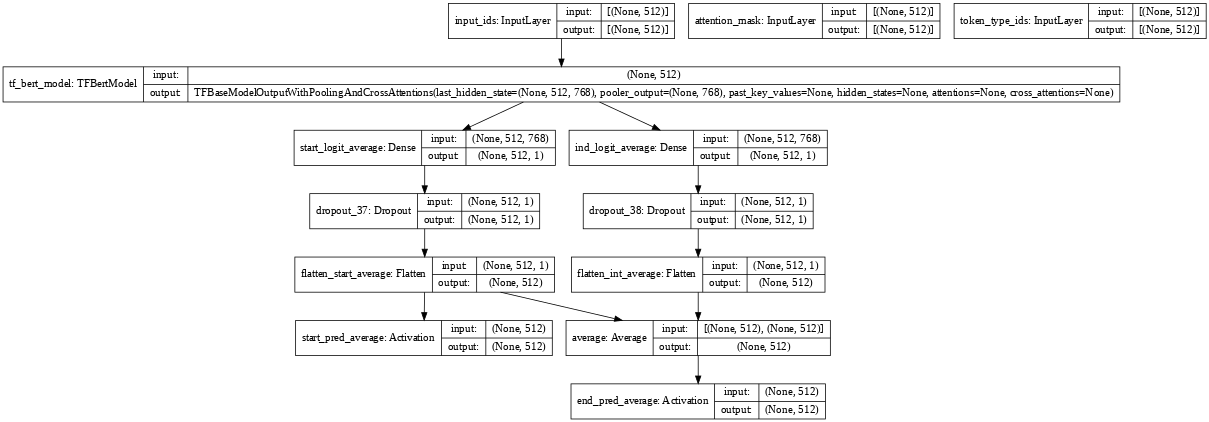

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - ETA: 0s - loss: 8.1052 - start_pred_average_loss: 4.3466 - end_pred_average_loss: 3.7587 - start_pred_average_accuracy: 0.2553 - end_pred_average_accuracy: 0.2706

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - 435s 667ms/step - loss: 8.1052 - start_pred_average_loss: 4.3466 - end_pred_average_loss: 3.7587 - start_pred_average_accuracy: 0.2553 - end_pred_average_accuracy: 0.2706 - val_loss: 3.8171 - val_start_pred_average_loss: 2.1068 - val_end_pred_average_loss: 1.7102 - val_start_pred_average_accuracy: 0.5667 - val_end_pred_average_accuracy: 0.6090

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_average.hdf5
Epoch 2/25
507/507 [==============================] - 260s 512ms/step - loss: 6.8207 - start_pred_average_loss: 3.8030 - end_pred_average_loss: 3.0177 - start_pred_average_accuracy: 0.3496 - end_pred_average_accuracy: 0.4197 - val_loss: 3.1597 - val_start_pred_average_loss: 1.7503 - val_end_pred_average_loss: 1.4095 - val_start_pred_average_accuracy: 0.6090 - val_end_pred_average_accuracy: 0.6540

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncase

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_average_loss', 'end_pred_average_loss', 'start_pred_average_accuracy', 'end_pred_average_accuracy', 'val_loss', 'val_start_pred_average_loss', 'val_end_pred_average_loss', 'val_start_pred_average_accuracy', 'val_end_pred_average_accuracy'])

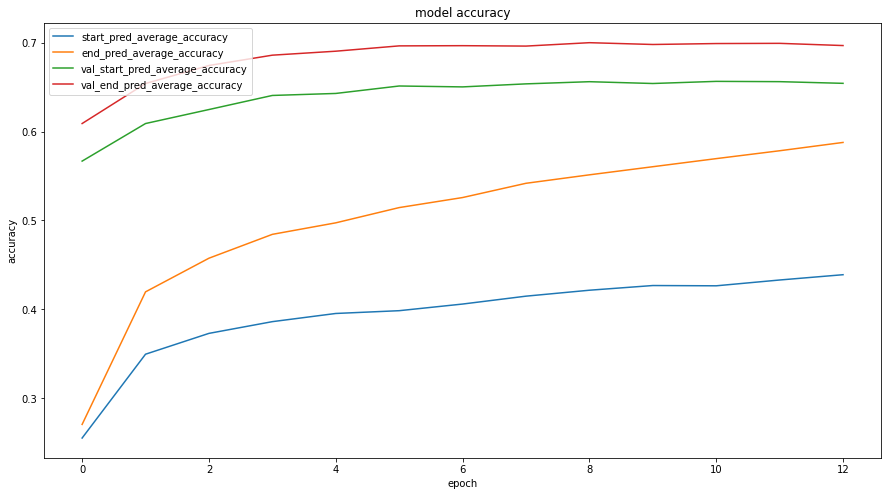

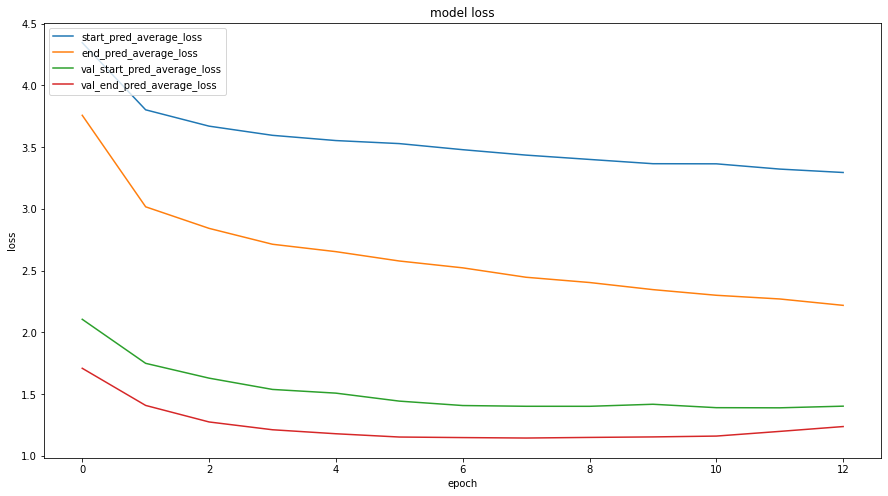

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["end_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["val_start_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["val_end_pred_" + layer_option + "_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["start_pred_" + layer_option + "_accuracy", "end_pred_" + layer_option + "_accuracy", "val_start_pred_" + layer_option + "_accuracy", "val_end_pred_" + layer_option + "_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history["start_pred_" + layer_option + "_loss"])
plt.plot(history.history["end_pred_" + layer_option + "_loss"])
plt.plot(history.history["val_start_pred_" + layer_option + "_loss"])
plt.plot(history.history["val_end_pred_" + layer_option + "_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["start_pred_" + layer_option + "_loss", "end_pred_" + layer_option + "_loss", "val_start_pred_" + layer_option + "_loss", "val_end_pred_" + layer_option + "_loss"], loc='upper left')
plt.show()

# Maximum 

In [ ]:
layer_option = "maximum" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer = layer_option, inputs=inputs)

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss=[loss, loss], metrics=["accuracy"])

model.summary()

DEBUG:filelock:Attempting to acquire lock 140229423822032 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140229423822032 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140229423822032 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140229423822032 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

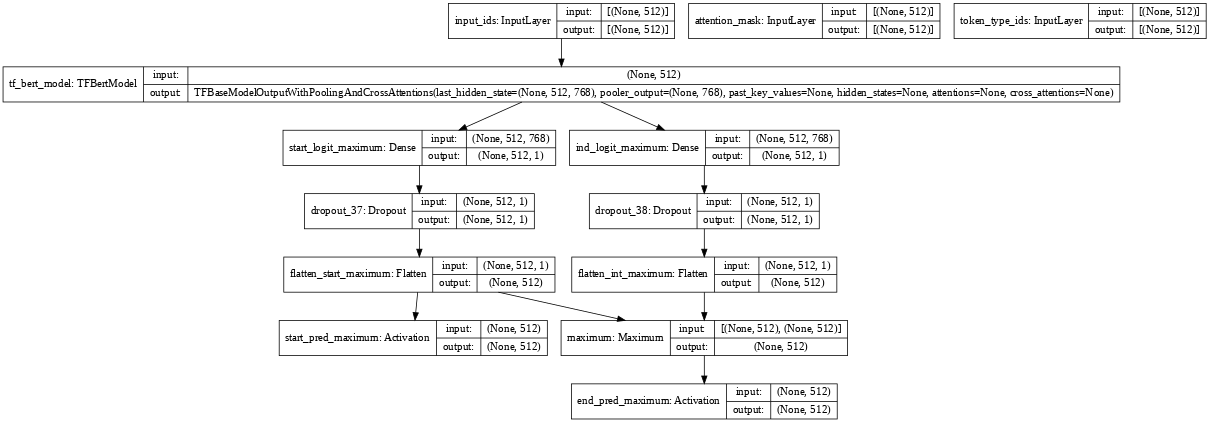

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)


In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - ETA: 0s - loss: 8.1051 - start_pred_maximum_loss: 4.4251 - end_pred_maximum_loss: 3.6800 - start_pred_maximum_accuracy: 0.2309 - end_pred_maximum_accuracy: 0.3262

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - 416s 656ms/step - loss: 8.1051 - start_pred_maximum_loss: 4.4251 - end_pred_maximum_loss: 3.6800 - start_pred_maximum_accuracy: 0.2309 - end_pred_maximum_accuracy: 0.3262 - val_loss: 4.4483 - val_start_pred_maximum_loss: 2.4054 - val_end_pred_maximum_loss: 2.0429 - val_start_pred_maximum_accuracy: 0.5100 - val_end_pred_maximum_accuracy: 0.6172

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_maximum.hdf5
Epoch 2/25
507/507 [==============================] - 257s 506ms/step - loss: 6.9063 - start_pred_maximum_loss: 3.9321 - end_pred_maximum_loss: 2.9743 - start_pred_maximum_accuracy: 0.3141 - end_pred_maximum_accuracy: 0.4553 - val_loss: 3.8043 - val_start_pred_maximum_loss: 1.9991 - val_end_pred_maximum_loss: 1.8052 - val_start_pred_maximum_accuracy: 0.5658 - val_end_pred_maximum_accuracy: 0.6545

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncase

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_maximum_loss', 'end_pred_maximum_loss', 'start_pred_maximum_accuracy', 'end_pred_maximum_accuracy', 'val_loss', 'val_start_pred_maximum_loss', 'val_end_pred_maximum_loss', 'val_start_pred_maximum_accuracy', 'val_end_pred_maximum_accuracy'])

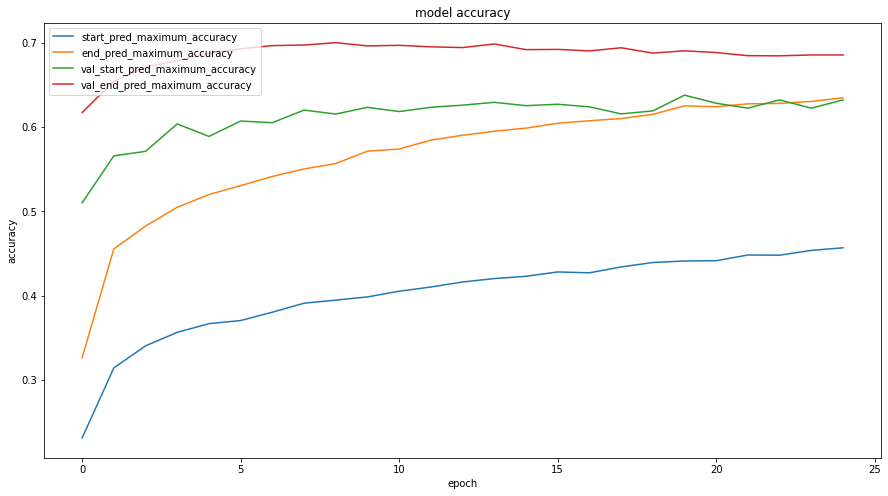

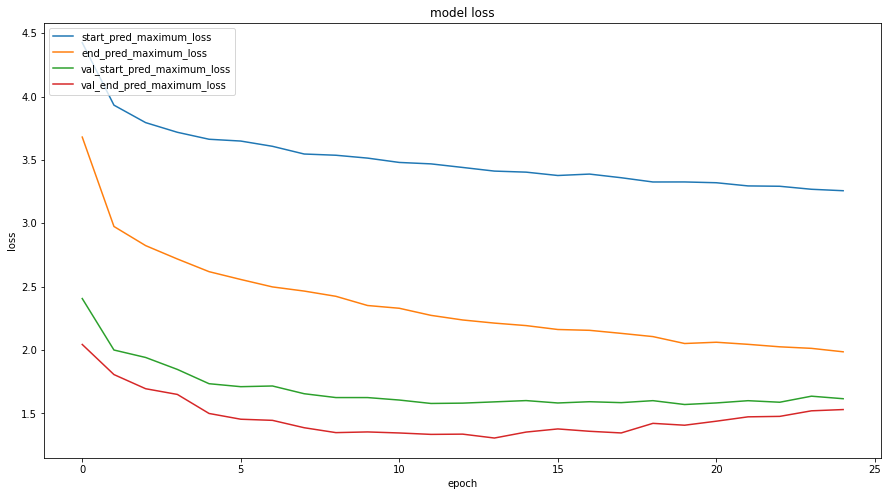

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["end_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["val_start_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["val_end_pred_" + layer_option + "_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["start_pred_" + layer_option + "_accuracy", "end_pred_" + layer_option + "_accuracy", "val_start_pred_" + layer_option + "_accuracy", "val_end_pred_" + layer_option + "_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history["start_pred_" + layer_option + "_loss"])
plt.plot(history.history["end_pred_" + layer_option + "_loss"])
plt.plot(history.history["val_start_pred_" + layer_option + "_loss"])
plt.plot(history.history["val_end_pred_" + layer_option + "_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["start_pred_" + layer_option + "_loss", "end_pred_" + layer_option + "_loss", "val_start_pred_" + layer_option + "_loss", "val_end_pred_" + layer_option + "_loss"], loc='upper left')
plt.show()

# Add 

In [ ]:
layer_option = "add" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option, inputs=inputs)

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

DEBUG:filelock:Attempting to acquire lock 140390571334672 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140390571334672 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140390571334672 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140390571334672 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

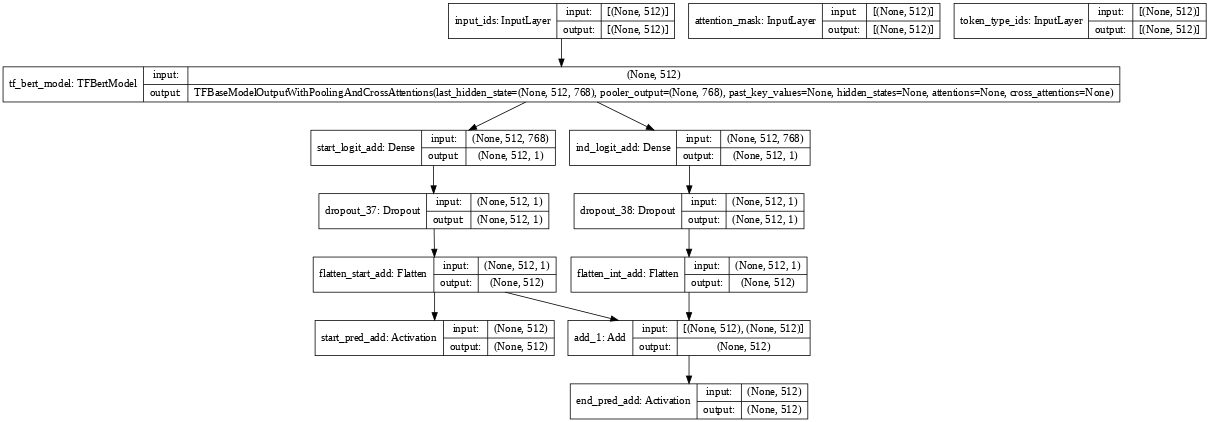

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=40,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/40


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - ETA: 0s - loss: 8.0909 - start_pred_add_loss: 4.3798 - end_pred_add_loss: 3.7111 - start_pred_add_accuracy: 0.2525 - end_pred_add_accuracy: 0.2793

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - 422s 663ms/step - loss: 8.0909 - start_pred_add_loss: 4.3798 - end_pred_add_loss: 3.7111 - start_pred_add_accuracy: 0.2525 - end_pred_add_accuracy: 0.2793 - val_loss: 3.8955 - val_start_pred_add_loss: 2.3644 - val_end_pred_add_loss: 1.5311 - val_start_pred_add_accuracy: 0.5608 - val_end_pred_add_accuracy: 0.6192

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_add.hdf5
Epoch 2/40
507/507 [==============================] - 256s 506ms/step - loss: 6.8240 - start_pred_add_loss: 3.8313 - end_pred_add_loss: 2.9926 - start_pred_add_accuracy: 0.3489 - end_pred_add_accuracy: 0.4176 - val_loss: 3.3862 - val_start_pred_add_loss: 2.0682 - val_end_pred_add_loss: 1.3180 - val_start_pred_add_accuracy: 0.6040 - val_end_pred_add_accuracy: 0.6601

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_add.hdf5
Epoch 3/40
507/507 [==============================] - 256

In [ ]:
history.history.keys()

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["end_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["val_start_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["val_end_pred_" + layer_option + "_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["start_pred_" + layer_option + "_accuracy", "end_pred_" + layer_option + "_accuracy", "val_start_pred_" + layer_option + "_accuracy", "val_end_pred_" + layer_option + "_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history["start_pred_" + layer_option + "_loss"])
plt.plot(history.history["end_pred_" + layer_option + "_loss"])
plt.plot(history.history["val_start_pred_" + layer_option + "_loss"])
plt.plot(history.history["val_end_pred_" + layer_option + "_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["start_pred_" + layer_option + "_loss", "end_pred_" + layer_option + "_loss", "val_start_pred_" + layer_option + "_loss", "val_end_pred_" + layer_option + "_loss"], loc='upper left')
plt.show()

# Minimum 

In [ ]:
layer_option = "minimum" 

In [ ]:
# Create distribution strategy
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

ES_start = EarlyStopping(monitor='val_start_pred_' + layer_option + '_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)
ES_end = EarlyStopping(monitor='val_end_pred_' + layer_option + '_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)

# def accuracy(y_true, y_pred):
#     sampled = tf.argmax(y_pred, axis=-1)
#     if len(sampled)==0:
#         return np.float64(1)   
#     acc = 1 - tf.math.count_nonzero(tf.squeeze(tf.cast(y_true, tf.int64)) - sampled) / tf.cast(len(sampled), tf.int64)
#     return acc

# Save the slow pretrained tokenizer
path = '/content/drive/MyDrive/NLP/proj finale/dataset'

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]
# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option, inputs=inputs)

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

DEBUG:filelock:Attempting to acquire lock 139906051544912 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 139906051544912 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139906051544912 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 139906051544912 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

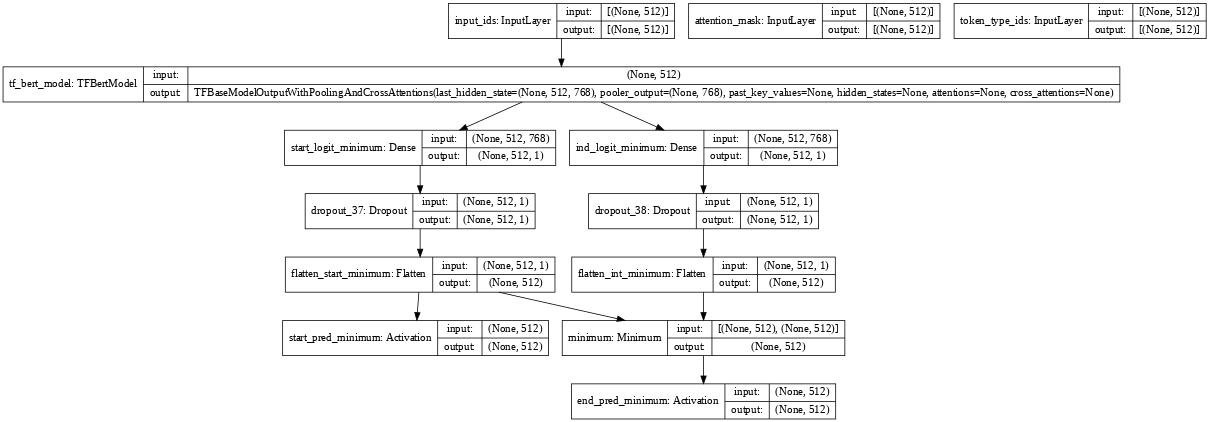

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)


In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=30,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/30


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - ETA: 0s - loss: 9.0727 - start_pred_minimum_loss: 4.3704 - end_pred_minimum_loss: 4.7023 - start_pred_minimum_accuracy: 0.2492 - end_pred_minimum_accuracy: 0.1451

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - 422s 660ms/step - loss: 9.0727 - start_pred_minimum_loss: 4.3704 - end_pred_minimum_loss: 4.7023 - start_pred_minimum_accuracy: 0.2492 - end_pred_minimum_accuracy: 0.1451 - val_loss: 4.2839 - val_start_pred_minimum_loss: 2.1308 - val_end_pred_minimum_loss: 2.1531 - val_start_pred_minimum_accuracy: 0.5572 - val_end_pred_minimum_accuracy: 0.5659

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_minimum.hdf5
Epoch 2/30
507/507 [==============================] - 257s 507ms/step - loss: 8.1268 - start_pred_minimum_loss: 3.8304 - end_pred_minimum_loss: 4.2964 - start_pred_minimum_accuracy: 0.3490 - end_pred_minimum_accuracy: 0.2007 - val_loss: 3.6361 - val_start_pred_minimum_loss: 1.8319 - val_end_pred_minimum_loss: 1.8042 - val_start_pred_minimum_accuracy: 0.6065 - val_end_pred_minimum_accuracy: 0.6231

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncase

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_minimum_loss', 'end_pred_minimum_loss', 'start_pred_minimum_accuracy', 'end_pred_minimum_accuracy', 'val_loss', 'val_start_pred_minimum_loss', 'val_end_pred_minimum_loss', 'val_start_pred_minimum_accuracy', 'val_end_pred_minimum_accuracy'])

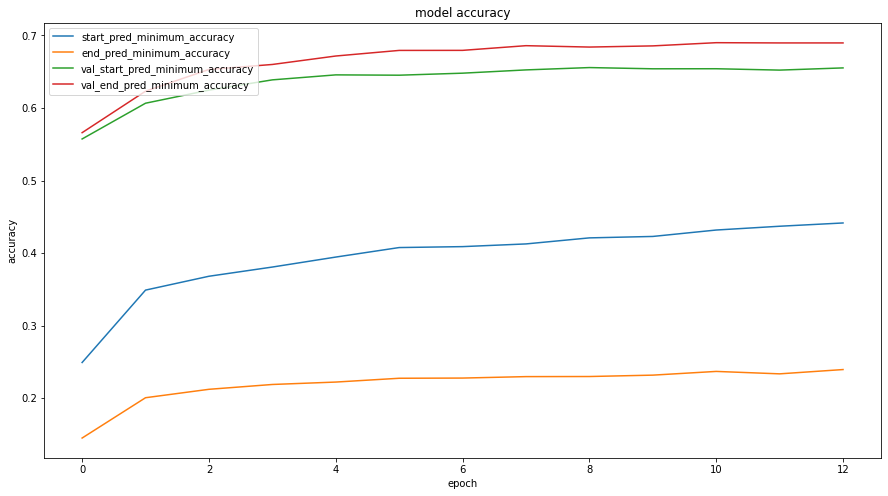

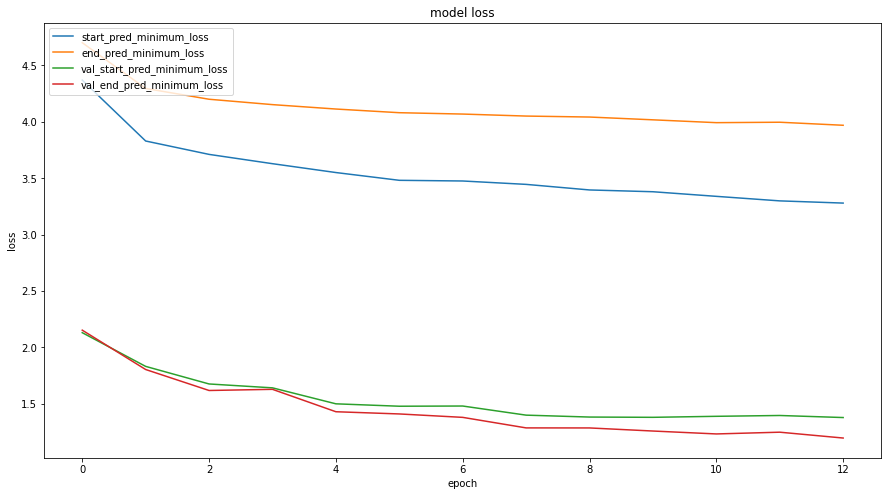

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["end_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["val_start_pred_" + layer_option + "_accuracy"])
plt.plot(history.history["val_end_pred_" + layer_option + "_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["start_pred_" + layer_option + "_accuracy", "end_pred_" + layer_option + "_accuracy", "val_start_pred_" + layer_option + "_accuracy", "val_end_pred_" + layer_option + "_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history["start_pred_" + layer_option + "_loss"])
plt.plot(history.history["end_pred_" + layer_option + "_loss"])
plt.plot(history.history["val_start_pred_" + layer_option + "_loss"])
plt.plot(history.history["val_end_pred_" + layer_option + "_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["start_pred_" + layer_option + "_loss", "end_pred_" + layer_option + "_loss", "val_start_pred_" + layer_option + "_loss", "val_end_pred_" + layer_option + "_loss"], loc='upper left')
plt.show()

# Subtract 

In [ ]:
layer_option = "subtract" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option, inputs= inputs)

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

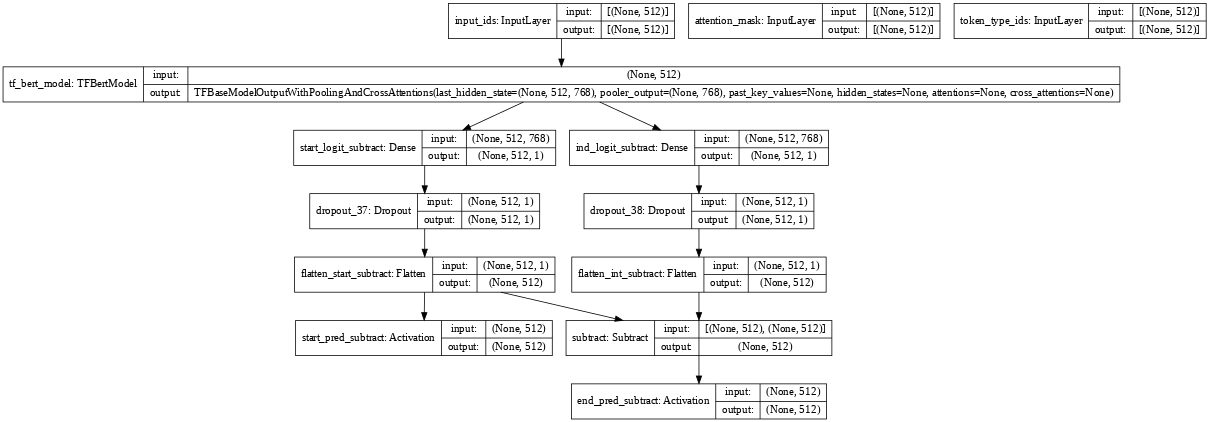

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)


In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - ETA: 0s - loss: 8.1616 - start_pred_subtract_loss: 4.4104 - end_pred_subtract_loss: 3.7512 - start_pred_subtract_accuracy: 0.2450 - end_pred_subtract_accuracy: 0.2716

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - 432s 668ms/step - loss: 8.1616 - start_pred_subtract_loss: 4.4104 - end_pred_subtract_loss: 3.7512 - start_pred_subtract_accuracy: 0.2450 - end_pred_subtract_accuracy: 0.2716 - val_loss: 3.9804 - val_start_pred_subtract_loss: 2.4751 - val_end_pred_subtract_loss: 1.5053 - val_start_pred_subtract_accuracy: 0.5498 - val_end_pred_subtract_accuracy: 0.6205

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_subtract.hdf5
Epoch 2/25
507/507 [==============================] - 259s 511ms/step - loss: 6.8173 - start_pred_subtract_loss: 3.8538 - end_pred_subtract_loss: 2.9635 - start_pred_subtract_accuracy: 0.3440 - end_pred_subtract_accuracy: 0.4186 - val_loss: 3.4357 - val_start_pred_subtract_loss: 2.1249 - val_end_pred_subtract_loss: 1.3107 - val_start_pred_subtract_accuracy: 0.5973 - val_end_pred_subtract_accuracy: 0.6581

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_subtract_loss', 'end_pred_subtract_loss', 'start_pred_subtract_accuracy', 'end_pred_subtract_accuracy', 'val_loss', 'val_start_pred_subtract_loss', 'val_end_pred_subtract_loss', 'val_start_pred_subtract_accuracy', 'val_end_pred_subtract_accuracy'])

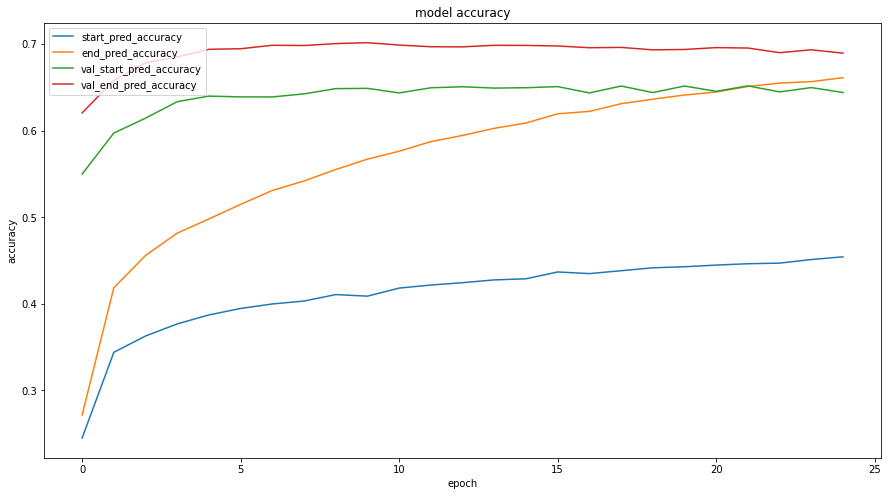

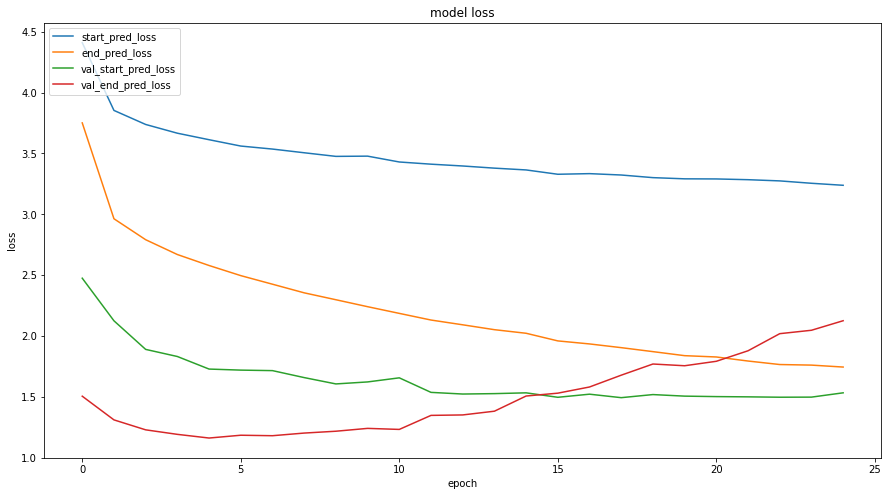

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_subtract_accuracy"])
plt.plot(history.history["end_pred_subtract_accuracy"])
plt.plot(history.history["val_start_pred_subtract_accuracy"])
plt.plot(history.history["val_end_pred_subtract_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_subtract_loss'])
plt.plot(history.history['end_pred_subtract_loss'])
plt.plot(history.history['val_start_pred_subtract_loss'])
plt.plot(history.history['val_end_pred_subtract_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()

# Multiply 

In [ ]:
layer_option = "multiply" 

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_custom(model_name, custom_layer=layer_option, inputs = inputs)

model.summary()

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

DEBUG:filelock:Attempting to acquire lock 139615917038608 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 139615917038608 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139615917038608 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 139615917038608 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

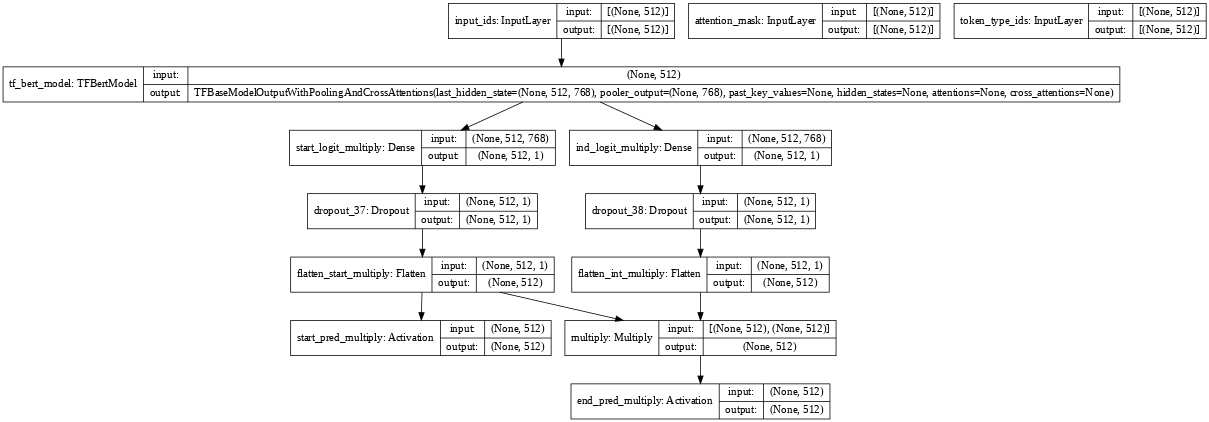

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - ETA: 0s - loss: 9.9591 - start_pred_multiply_loss: 4.5115 - end_pred_multiply_loss: 5.4476 - start_pred_multiply_accuracy: 0.2267 - end_pred_multiply_accuracy: 0.1328

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - 423s 661ms/step - loss: 9.9591 - start_pred_multiply_loss: 4.5115 - end_pred_multiply_loss: 5.4476 - start_pred_multiply_accuracy: 0.2267 - end_pred_multiply_accuracy: 0.1328 - val_loss: 5.8835 - val_start_pred_multiply_loss: 2.4560 - val_end_pred_multiply_loss: 3.4276 - val_start_pred_multiply_accuracy: 0.5450 - val_end_pred_multiply_accuracy: 0.5643

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_multiply.hdf5
Epoch 2/25
507/507 [==============================] - 256s 506ms/step - loss: 8.8626 - start_pred_multiply_loss: 3.8274 - end_pred_multiply_loss: 5.0352 - start_pred_multiply_accuracy: 0.3479 - end_pred_multiply_accuracy: 0.1957 - val_loss: 4.8708 - val_start_pred_multiply_loss: 2.0119 - val_end_pred_multiply_loss: 2.8590 - val_start_pred_multiply_accuracy: 0.6043 - val_end_pred_multiply_accuracy: 0.6288

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models

In [ ]:
history.history.keys()

dict_keys(['loss', 'start_pred_multiply_loss', 'end_pred_multiply_loss', 'start_pred_multiply_accuracy', 'end_pred_multiply_accuracy', 'val_loss', 'val_start_pred_multiply_loss', 'val_end_pred_multiply_loss', 'val_start_pred_multiply_accuracy', 'val_end_pred_multiply_accuracy'])

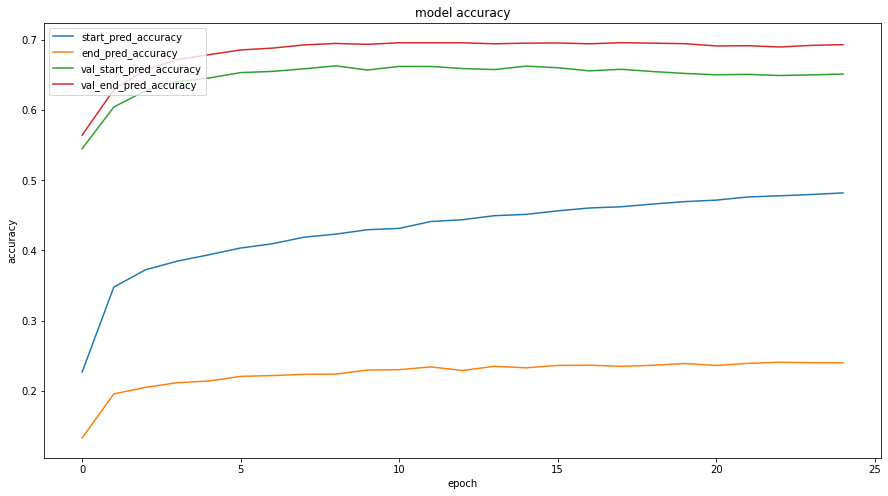

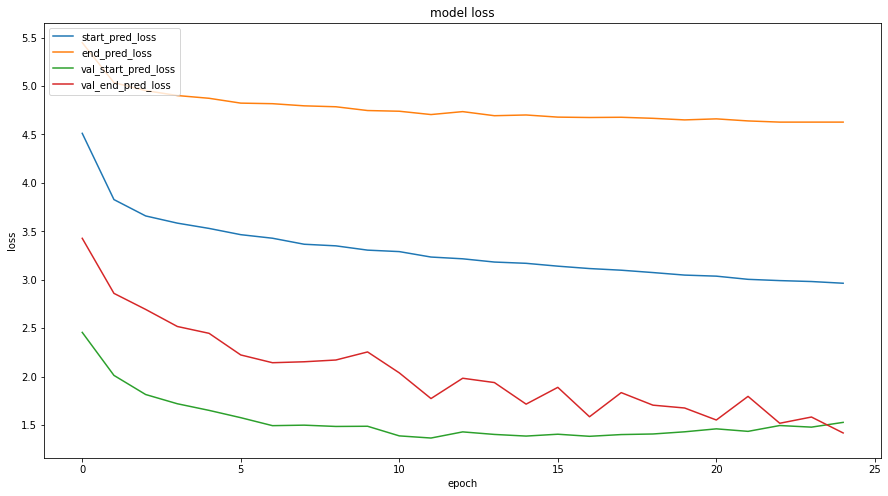

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_multiply_accuracy"])
plt.plot(history.history["end_pred_multiply_accuracy"])
plt.plot(history.history["val_start_pred_multiply_accuracy"])
plt.plot(history.history["val_end_pred_multiply_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_multiply_loss'])
plt.plot(history.history['end_pred_multiply_loss'])
plt.plot(history.history['val_start_pred_multiply_loss'])
plt.plot(history.history['val_end_pred_multiply_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()

# Vanilla

In [ ]:
layer_option = "vanilla"

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'
ES_start = EarlyStopping(monitor='val_start_pred_vanilla_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)
ES_end = EarlyStopping(monitor='val_end_pred_vanilla_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)


cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)


# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_vanilla(model_name, inputs = inputs)

model.summary()

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

Running on TPU  ['10.114.208.34:8470']


DEBUG:filelock:Attempting to acquire lock 140456846907216 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140456846907216 acquired on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140456846907216 on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
DEBUG:filelock:Lock 140456846907216 released on /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5.lock
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mo

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

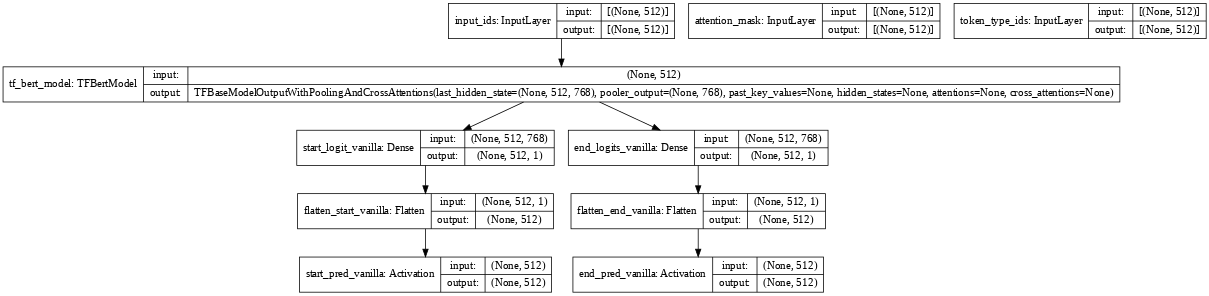

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - ETA: 0s - loss: 4.1879 - start_pred_vanilla_loss: 2.1392 - end_pred_vanilla_loss: 2.0487 - start_pred_vanilla_accuracy: 0.4552 - end_pred_vanilla_accuracy: 0.4870

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - 417s 660ms/step - loss: 4.1879 - start_pred_vanilla_loss: 2.1392 - end_pred_vanilla_loss: 2.0487 - start_pred_vanilla_accuracy: 0.4552 - end_pred_vanilla_accuracy: 0.4870 - val_loss: 2.8209 - val_start_pred_vanilla_loss: 1.4542 - val_end_pred_vanilla_loss: 1.3667 - val_start_pred_vanilla_accuracy: 0.5938 - val_end_pred_vanilla_accuracy: 0.6332

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_vanilla.hdf5
Epoch 2/25
507/507 [==============================] - 256s 506ms/step - loss: 2.3901 - start_pred_vanilla_loss: 1.2388 - end_pred_vanilla_loss: 1.1513 - start_pred_vanilla_accuracy: 0.6400 - end_pred_vanilla_accuracy: 0.6763 - val_loss: 2.4964 - val_start_pred_vanilla_loss: 1.3046 - val_end_pred_vanilla_loss: 1.1918 - val_start_pred_vanilla_accuracy: 0.6302 - val_end_pred_vanilla_accuracy: 0.6703

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncase

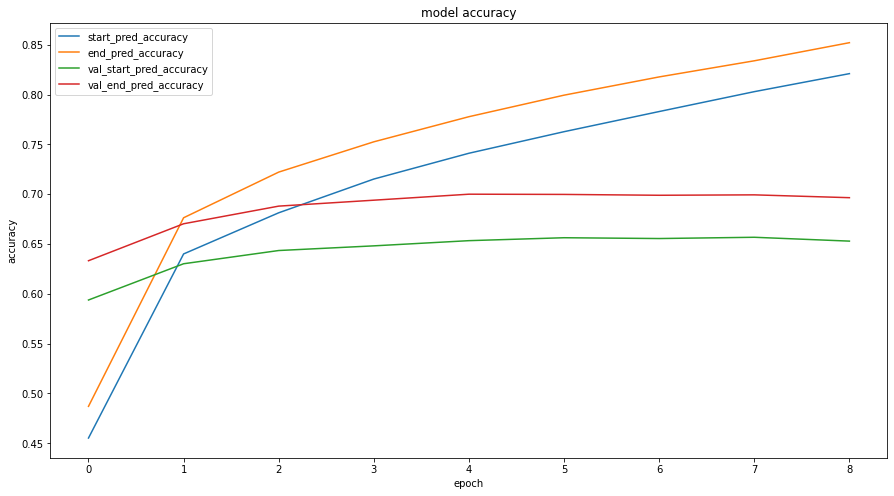

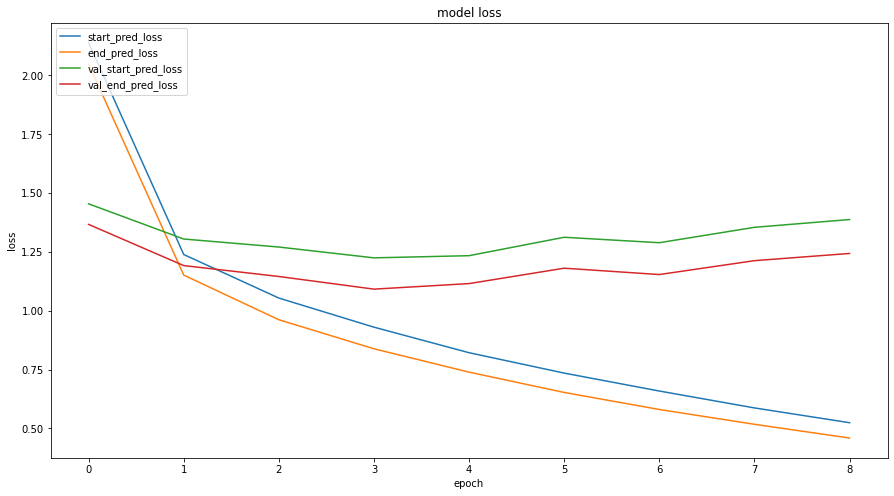

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_vanilla_accuracy"])
plt.plot(history.history["end_pred_vanilla_accuracy"])
plt.plot(history.history["val_start_pred_vanilla_accuracy"])
plt.plot(history.history["val_end_pred_vanilla_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_vanilla_loss'])
plt.plot(history.history['end_pred_vanilla_loss'])
plt.plot(history.history['val_start_pred_vanilla_loss'])
plt.plot(history.history['val_end_pred_vanilla_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()

# CNN

In [ ]:
layer_option = "cnn"

In [ ]:
chkpt = save_path + model_name + '_' + layer_option + '.hdf5'
ES_start = EarlyStopping(monitor='val_start_pred_cnn_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)
ES_end = EarlyStopping(monitor='val_end_pred_cnn_accuracy', patience=4,verbose=1, mode='auto', restore_best_weights = True)


cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [ES_end, ES_start, cp_cb]

# BERT e Bert tokenizer following model_name
# Create model
with strategy.scope():
    model = create_bert_CNN(model_name, inputs = inputs)

model.summary()

model.compile(optimizer=optimizer, loss=[loss, loss], metrics=[accuracy])
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

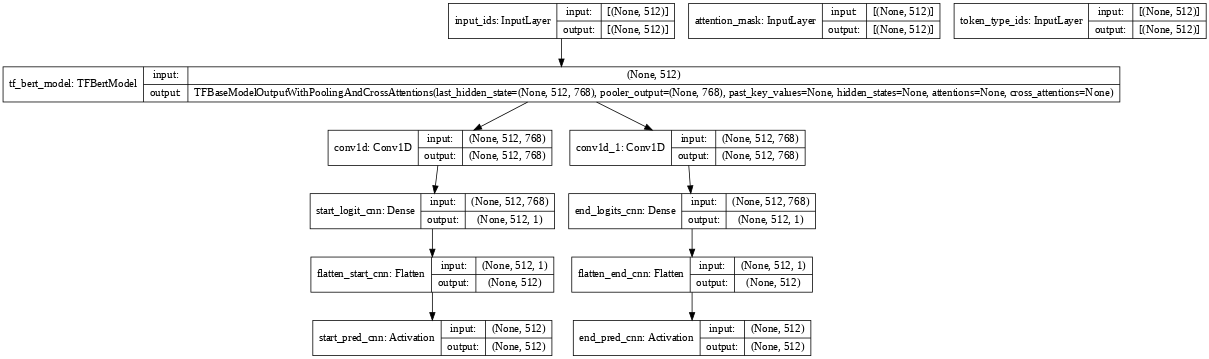

In [ ]:
tf.keras.utils.plot_model(model, dpi=55, show_shapes=True)

In [ ]:
history = model.fit(
            x_train,
            y_train,
            epochs=25,  # For demonstration, 3 epochs are recommended
            verbose=1,
            batch_size=128,
            validation_data=(x_val,y_val),
            callbacks = callbacks)

Epoch 1/25


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - ETA: 0s - loss: 3.8321 - start_pred_cnn_loss: 1.9531 - end_pred_cnn_loss: 1.8790 - start_pred_cnn_accuracy: 0.4911 - end_pred_cnn_accuracy: 0.5160

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'cond_8/Identity_4:0' shape=(None,) dtype=float32>]


507/507 [==============================] - 459s 723ms/step - loss: 3.8321 - start_pred_cnn_loss: 1.9531 - end_pred_cnn_loss: 1.8790 - start_pred_cnn_accuracy: 0.4911 - end_pred_cnn_accuracy: 0.5160 - val_loss: 2.7285 - val_start_pred_cnn_loss: 1.4020 - val_end_pred_cnn_loss: 1.3265 - val_start_pred_cnn_accuracy: 0.6010 - val_end_pred_cnn_accuracy: 0.6403

Epoch 00001: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_cnn.hdf5
Epoch 2/25
507/507 [==============================] - 275s 542ms/step - loss: 2.2935 - start_pred_cnn_loss: 1.1812 - end_pred_cnn_loss: 1.1123 - start_pred_cnn_accuracy: 0.6526 - end_pred_cnn_accuracy: 0.6877 - val_loss: 2.4551 - val_start_pred_cnn_loss: 1.2777 - val_end_pred_cnn_loss: 1.1774 - val_start_pred_cnn_accuracy: 0.6344 - val_end_pred_cnn_accuracy: 0.6754

Epoch 00002: saving model to /content/drive/MyDrive/NLP/proj finale/saved_models/bert-base-uncased_cnn.hdf5
Epoch 3/25
507/507 [==============================] - 275

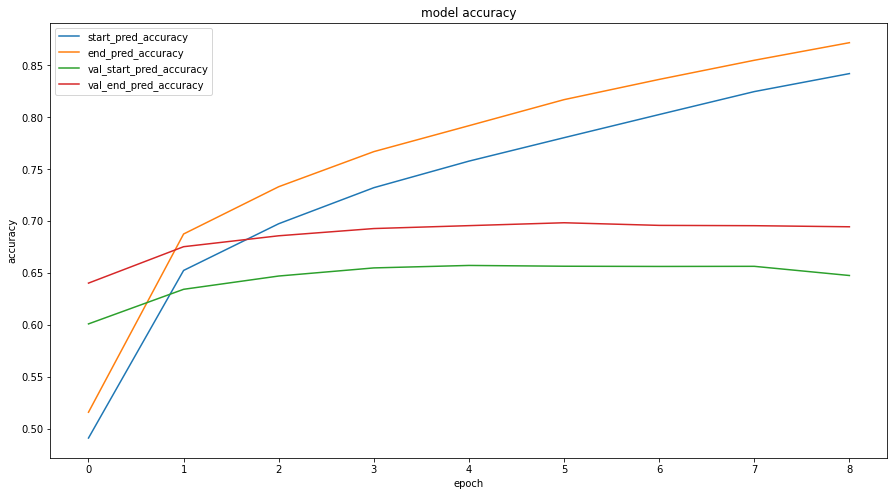

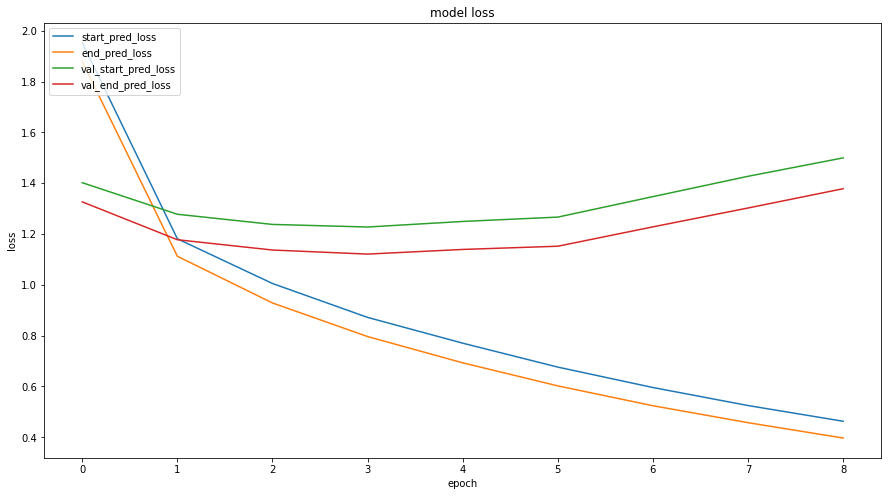

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(history.history["start_pred_cnn_accuracy"])
plt.plot(history.history["end_pred_cnn_accuracy"])
plt.plot(history.history["val_start_pred_cnn_accuracy"])
plt.plot(history.history["val_end_pred_cnn_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['start_pred_accuracy', 'end_pred_accuracy', "val_start_pred_accuracy", "val_end_pred_accuracy"], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15,8))

plt.plot(history.history['start_pred_cnn_loss'])
plt.plot(history.history['end_pred_cnn_loss'])
plt.plot(history.history['val_start_pred_cnn_loss'])
plt.plot(history.history['val_end_pred_cnn_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['start_pred_loss', 'end_pred_loss', "val_start_pred_loss", "val_end_pred_loss"], loc='upper left')
plt.show()